In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A simple quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

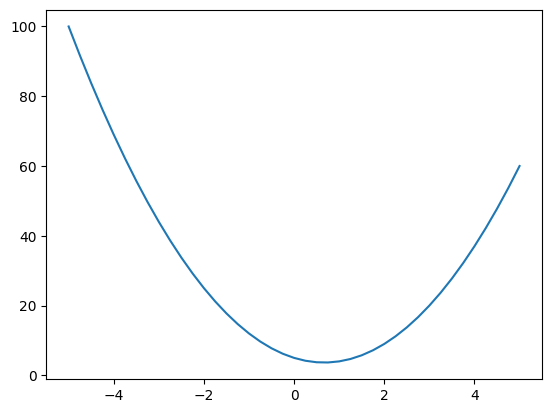

In [3]:
xs = np.arange(-5.0, 5.25, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [78]:
class Value:
    def __init__(self, data, _children=(), _operations='', label=''):
        self.data = data
        self._prev = set(_children)
        self._operations = _operations
        self.label = label
        self.gradient = 0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(label={self.label}, data={self.data})"

    def set_label(self, l=''):
        self.label = l

    def set_gradient(self, g=0):
        self.gradient = g

    def __add__(self, val):
        output = Value(self.data + val.data, (self, val), '+')

        def _backward():
            self.gradient += 1.0 * output.gradient
            val.gradient += 1.0 * output.gradient
        output._backward = _backward
        
        return output

    def __mul__(self, val):
        output = Value(self.data * val.data, (self, val), '*')
        
        def _backward():
            self.gradient += val.data * output.gradient
            val.gradient += self.data * output.gradient
        output._backward = _backward

        return output

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Value(t, (self,), 'tanh')
        
        def _backward():
            self.gradient += (1 - t**2) * output.gradient
        output._backward = _backward
        
        return output

    def backward(self):
        topo_sorted_list = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_sorted_list.append(v)
        
        build_topo(self)
        self.set_gradient(1.0)
        
        for node in reversed(topo_sorted_list):
            node._backward()


In [5]:
from graphviz import Digraph

In [6]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
    
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient,), shape='record')
    if n._operations:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operations, label = n._operations)
      # and connect this node to it
      dot.edge(uid + n._operations, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operations)

  return dot

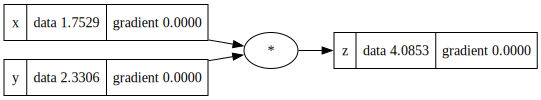

In [7]:
x = Value(1.7529, label='x')
y = Value(2.3306, label='y')
z = x * y
z.set_label('z')
draw_dot(z)

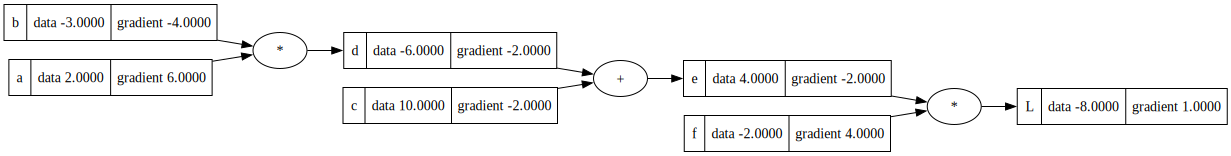

In [8]:
def find_derivatives(): 
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a * b
    d.set_label('d')
    e = d + c
    e.set_label('e')
    f = Value(-2.0, label='f')
    L = e * f
    L.set_label('L')

    # 1. By Default gradient of L is 1.0 i.e. dL/dL = 1
    L.set_gradient(1.0)

    # As L = e * f 
    
    # 2. dL/de = f | i.e. e.grad = f (-2)
    e.set_gradient(f.data)
    
    # 3. dL/df = e | i.e. f.grad = e (4)
    f.set_gradient(e.data)

    # 4. dL/dc = ?
    # dL/dc = de/dc * dL/de
    
    # e = c + d
    # de/dc = 1 

    # dL/dc = de/dc * dL/de | 1 * -2
    # dL/dc = -2
    c.set_gradient(-2)
    d.set_gradient(-2)

    # 5.  
    a.set_gradient(d.gradient * b.data)
    b.set_gradient(d.gradient * a.data)
    
    return draw_dot(L)

find_derivatives()

In [9]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a * b
    d.set_label('d')
    e = d + c
    e.set_label('e')
    f = Value(-2.0, label='f')
    L = e * f
    L.set_label('L')
    L1 = L.data

    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    d = a * b
    d.set_label('d')
    e = d + c
    # e.data += h
    e.set_label('e')
    f = Value(-2.0, label='f')
    L = e * f
    L.set_label('L')
    L2 = L.data
    
    print((L2 - L1) / h)

lol()

0.0


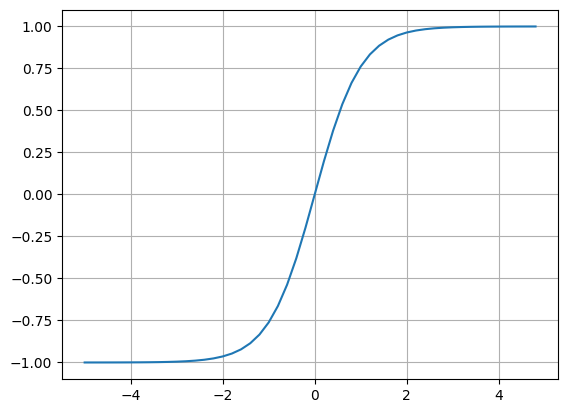

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [11]:
# Manual Backpropagation

# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 
x1w1.set_label('x1*w1')

x2w2 = x2*w2
x2w2.set_label('x2*w2')

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.set_label('x1*w1 + x2*w2')

n = x1w1x2w2 + b
n.set_label('n')

o = n.tanh()
o.set_label('o')

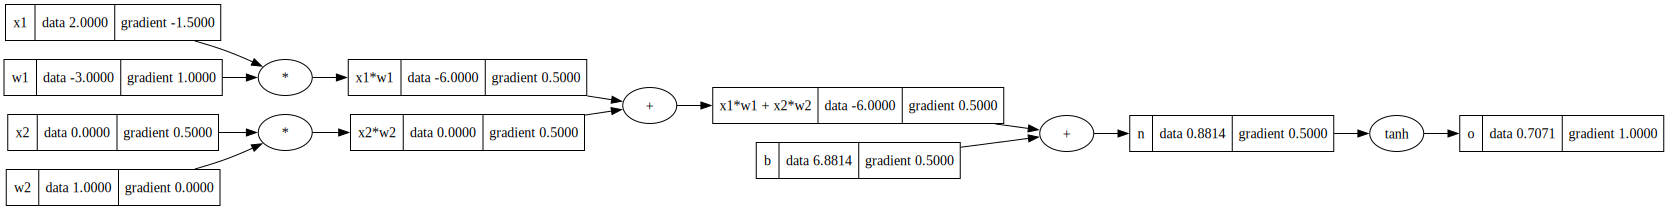

In [33]:
draw_dot(o)

In [13]:
# Set default grad of o is 1
o.set_gradient(1.0)

In [14]:
# Rules -> d tanh x  / dx = 1 - (tanh x) ^ 2
# o = tanh(n)
# do/dn = 1 - o ** 2

n.set_gradient(1 - o.data ** 2)


In [24]:
# As (x1w1 + x2w2) + b so both the local gradient is 1 
# and it will carry forward gradient of n
x1w1x2w2.set_gradient(n.gradient)
b.set_gradient(n.gradient)

In [25]:
# As x1w1 + x2w2 so both the local gradient is 1 
# and it will carry forward gradient of x1w1x2w2
x1w1.set_gradient(x1w1x2w2.gradient)
x2w2.set_gradient(x1w1x2w2.gradient)

In [26]:
# x1's local gradient is -3, due to chain rule it will be multiplied by gradient of x1w1 i.e. 0.5
x1.set_gradient(x1w1.gradient * w1.data)

In [28]:
# w1's local gradient is +2, due to chain rule it will be multiplied by gradient of x1w1 i.e. 0.5
w1.set_gradient(x1w1.gradient * x1.data)

In [30]:
# x2's local gradient is +1, due to chain rule it will be multiplied by gradient of x2w2 i.e. 0.5
x2.set_gradient(x2w2.gradient * w2.data)

In [32]:
# w2's local gradient is 0, due to chain rule it will be multiplied by gradient of x2w2 i.e. 0.5
w2.set_gradient(x2w2.gradient * x2.data)

In [64]:
# Reset the graph's gradient to ZERO

# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 
x1w1.set_label('x1*w1')

x2w2 = x2*w2
x2w2.set_label('x2*w2')

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.set_label('x1*w1 + x2*w2')

n = x1w1x2w2 + b
n.set_label('n')

o = n.tanh()
o.set_label('o')

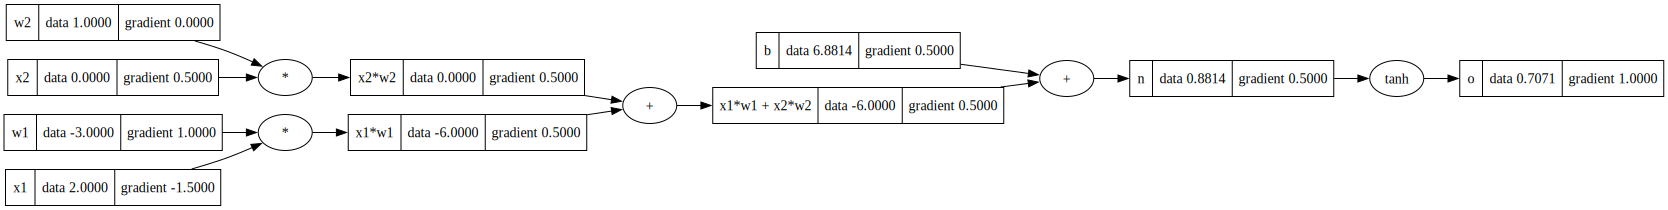

In [68]:
draw_dot(o)

In [48]:
# Implementing the _backward function for each operation
o.set_gradient(1.0)
o._backward() # should update n's gradient

In [54]:
n._backward() # should update both x1w1x2w2's & b's gradient

In [55]:
x1w1x2w2._backward() # should update both x1w1's & x2w2's gradient

In [57]:
x1w1._backward() # should update both x1's & w1's gradient

In [59]:
x2w2._backward() # should update both x2's & w2's gradient

In [67]:
# Topological Sorting - implementing the backward function for a whole expression graph
topo_sorted_list = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo_sorted_list.append(v)
build_topo(o)
o.set_gradient(1.0)

for node in reversed(topo_sorted_list):
    node._backward()

In [73]:
# Now all backward of o
# Reset Graph

# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 
x1w1.set_label('x1*w1')

x2w2 = x2*w2
x2w2.set_label('x2*w2')

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.set_label('x1*w1 + x2*w2')

n = x1w1x2w2 + b
n.set_label('n')

o = n.tanh()
o.set_label('o')

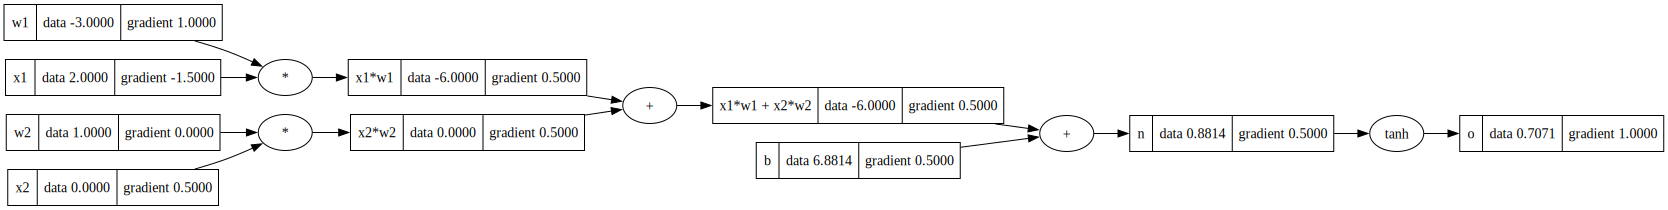

In [76]:
draw_dot(o)

In [75]:
o.backward()

In [ ]:
# Trying to replicate a tiny neural network 